# Анализ убытков приложения ProcrastinatePRO+

**Описание проекта**

Последние несколько месяцев компания терпит убытки. Задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
   * лог сервера с данными об их посещениях
   * выгрузка их покупок за этот период
   * рекламные расходы
Необходимо изучить:
   * откуда приходят пользователи и какими устройствами они пользуются
   * сколько стоит привлечение пользователей из различных рекламных каналов
   * сколько денег приносит каждый клиент
   * когда расходы на привлечение клиента окупаются
   * какие факторы мешают привлечению клиентов

**Описание данных**

В распоряжении три датасета. Файл **visits_info_short.csv** хранит лог сервера с информацией о посещениях сайта, **orders_info_short.csv** — информацию о заказах, а **costs_info_short.csv** — информацию о расходах на рекламу.

**Структура visits_info_short.csv:**
   * User Id — уникальный идентификатор пользователя
   * Region — страна пользователя
   * Device — тип устройства пользователя
   * Channel — идентификатор источника перехода
   * Session Start — дата и время начала сессии
   * Session End — дата и время окончания сессии

**Структура orders_info_short.csv:**
   * User Id — уникальный идентификатор пользователя
   * Event Dt — дата и время покупки
   * Revenue — сумма заказа

**Структура costs_info_short.csv:**
   * dt — дата проведения рекламной кампании
   * Channel — идентификатор рекламного источника
   * costs — расходы на эту кампанию

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Загрузка данных из CSV-файлов
try:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
    )
except:
    visits, orders, costs = (
    pd.read_csv(r'C:\Users\tarko\OneDrive\Рабочий стол\Анализ данных\Проекты\visits_info_short.csv'),
    pd.read_csv(r'C:\Users\tarko\OneDrive\Рабочий стол\Анализ данных\Проекты\orders_info_short.csv'),
    pd.read_csv(r'C:\Users\tarko\OneDrive\Рабочий стол\Анализ данных\Проекты\costs_info_short.csv')
    )

In [3]:
# Выводим таблицы исходных данныйх
display(visits)
display(orders)
display(costs)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


### Предобработка данных

In [4]:
# Приведение названий колонок к нижнему регистру
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

# Приведение всех значений к нижнему регистру в датасете visits_data
visits = visits.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Приведение всех значений к нижнему регистру в датасете orders_data
orders = orders.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# Приведение всех значений к нижнему регистру в датасете costs_data
costs = costs.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# выводим таблицы исходных данных с изменениями
display(visits)
display(orders)
display(costs)

,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,united states,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,united states,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,united states,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,united states,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,uk,pc,leapbob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,france,pc,lambdamediaads,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,germany,pc,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,germany,mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1
...,...,...,...
1795,2019-10-23,lambdamediaads,4.0
1796,2019-10-24,lambdamediaads,6.4
1797,2019-10-25,lambdamediaads,8.8
1798,2019-10-26,lambdamediaads,8.8


#### Проверка наличия пропусков и дубликатов visits

In [5]:
# Создайте список ваших загруженных таблиц
dataframes = [visits, orders, costs]

# Заголовок для проверки дубликатов
print('\033[1m' + 'Наличие дубликатов в таблице:' + '\033[0m')

# Цикл для обхода всех таблиц
for df in dataframes:
    # Вывод информации о таблице
    display(df)
    display(df.info())

    # Проверка наличия пропусков
    missing = df.isnull().sum()
    display(missing)

    # Вывод доли пропусков с цветовой градацией
    display(pd.DataFrame(round(df.isna().mean().sort_values(ascending=False)*100, 1)).style.background_gradient('coolwarm'))

    # Проверка наличия дубликатов
    duplicates = df.duplicated().sum()
    print(f"Дубликатов: {duplicates}\n")

Наличие дубликатов в таблице:


,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,united states,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,united states,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,united states,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,united states,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,uk,pc,leapbob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,france,pc,lambdamediaads,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,germany,pc,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,germany,mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

,0
user_id,0.000000
region,0.000000
device,0.000000
channel,0.000000
session_start,0.000000
session_end,0.000000


Дубликатов: 0



,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

user_id     0
event_dt    0
revenue     0
dtype: int64

,0
user_id,0.000000
event_dt,0.000000
revenue,0.000000


Дубликатов: 0



,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1
...,...,...,...
1795,2019-10-23,lambdamediaads,4.0
1796,2019-10-24,lambdamediaads,6.4
1797,2019-10-25,lambdamediaads,8.8
1798,2019-10-26,lambdamediaads,8.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

dt         0
channel    0
costs      0
dtype: int64

,0
dt,0.000000
channel,0.000000
costs,0.000000


Дубликатов: 0



In [6]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

**Вывод**

На основе исходных данных, провели проверку качества данных и предобработку данных в трех DataFrame: visits (визиты), orders (заказы) и costs (затраты).

**Данные о визитах (visits):**
   * Пропущенные значения: Отсутствуют.
   * Дубликаты: Отсутствуют.
   
**Данные о заказах (orders):**
   * Пропущенные значения: Отсутствуют.
   * Дубликаты: Отсутствуют.

**Данные о затратах (costs):**
   * Пропущенные значения: Отсутствуют.
   * Дубликаты: Отсутствуют.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [7]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
     
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [8]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [11]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [12]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [13]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

#### Составляем профили пользователей. Определяем минимальную и максимальную даты привлечения пользователей.

In [15]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)

display(profiles)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,united states,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iphone,united states,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,united states,2019-10-02,2019-10-02 00:07:44,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,tiptop,iphone,united states,2019-09-28,2019-09-28 08:33:02,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,pc,uk,2019-10-21,2019-10-21 00:35:17,False,0.000000
150005,999976332130,2019-07-23 02:57:06,tiptop,iphone,united states,2019-07-23,2019-07-23 02:57:06,False,2.600000
150006,999979924135,2019-09-28 21:28:09,mediatornado,pc,united states,2019-09-28,2019-09-28 21:28:09,False,0.205714


In [16]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())

Минимальная дата привлечения пользователей: 2019-05-01


In [17]:
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Максимальная дата привлечения пользователей: 2019-10-27


Сравнив эти даты с условиями технического задания, видно, что они соответствуют указанному временному интервалу с 1 мая 2019 года по 27 октября 2019 года. Это означает, что можно использовать данные в этом временном интервале для анализа и выполнения всех задач, перечисленных в техническом задании.

#### Доля платящих пользователей по странам, устройствам и каналам привлечения

,region,count_user_id,count_payer,share_payer
3,united states,100002,6902,6.901862
1,germany,14981,616,4.111875
2,uk,17575,700,3.982930
0,france,17450,663,3.799427


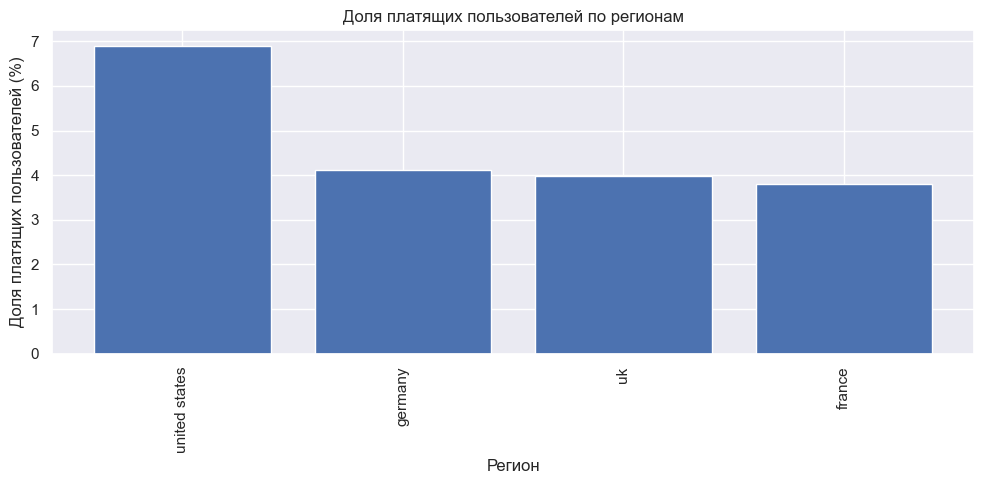

,device,count_user_id,count_payer,share_payer
2,mac,30042,1912,6.364423
1,iphone,54479,3382,6.207897
0,android,35032,2050,5.851793
3,pc,30455,1537,5.046790


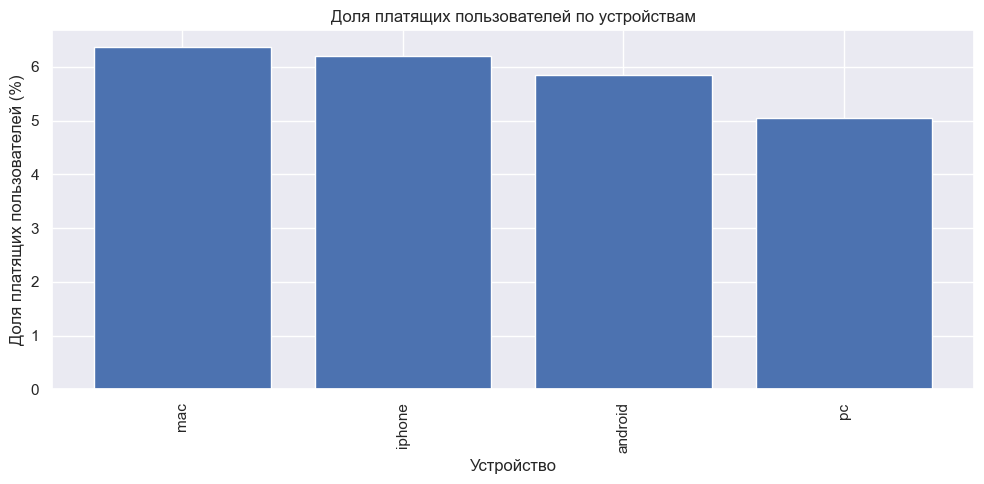

,channel,count_user_id,count_payer,share_payer
1,faceboom,29144,3557,12.204914
0,adnonsense,3880,440,11.340206
2,lambdamediaads,2149,225,10.469986
8,tiptop,19561,1878,9.600736
7,rocketsuperads,4448,352,7.913669
9,wahoonetbanner,8553,453,5.296387
10,yrabbit,4312,165,3.826531
4,mediatornado,4364,156,3.574702
3,leapbob,8553,262,3.063253
5,opplecreativemedia,8605,233,2.707728


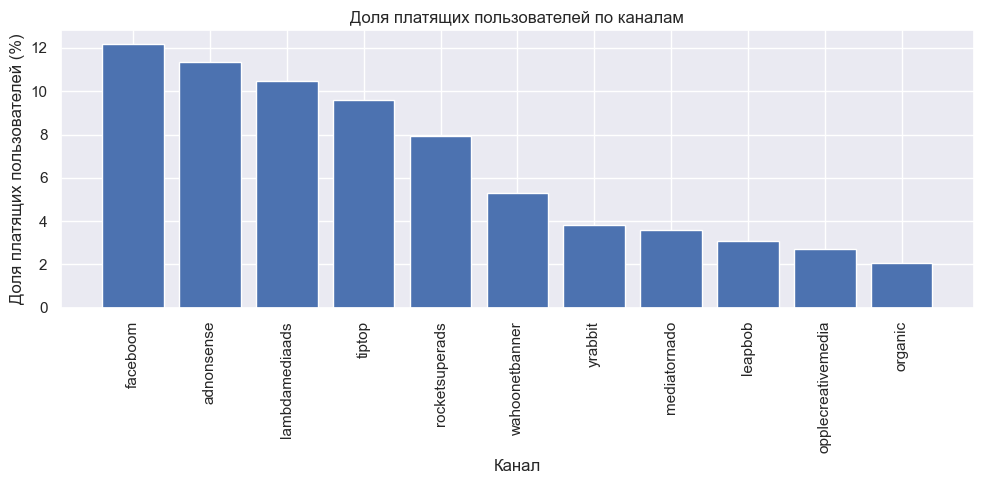

In [18]:
# Функция для агрегации данных, создания таблицы и форматирования значений
def generate_table_and_format(data, group_column, label_column, title, format_percentage=False, precision=2):
    # Агрегируем данные
    grouped_data = data.groupby(group_column)['payer'].agg(['count', 'sum']).reset_index()
    grouped_data.columns = [group_column, 'count_user_id', 'count_payer']
    grouped_data['share_payer'] = (grouped_data['count_payer'] / grouped_data['count_user_id']) * 100
    grouped_data = grouped_data.sort_values(by='share_payer', ascending=False)

    # Форматируем значения в колонке с долей платящих пользователей
    if format_percentage:
        grouped_data['share_payer'] = grouped_data['share_payer'].apply(lambda x: f"{x:.{precision}f}%")

    # Выводим таблицу
    display(grouped_data.style.format({label_column: '{:.2f}'}).background_gradient(cmap='Blues', axis=0))

    # Создаем график
    plt.figure(figsize=(10, 5))  # Задаем размер графика
    
    plt.bar(grouped_data[group_column], grouped_data['share_payer'])

    # Добавляем подписи и заголовок
    plt.xlabel(label_column)
    plt.ylabel('Доля платящих пользователей (%)')
    plt.title(title)

    # Поворачиваем подписи на оси x для лучшей читаемости
    plt.xticks(rotation=90)

    # Отображаем график
    plt.tight_layout()  # Улучшает компоновку графика
    plt.show()

# Производим анализ для регионов, устройств и каналов
generate_table_and_format(profiles, 'region', 'Регион', 'Доля платящих пользователей по регионам')
generate_table_and_format(profiles, 'device', 'Устройство', 'Доля платящих пользователей по устройствам')
generate_table_and_format(profiles, 'channel', 'Канал', 'Доля платящих пользователей по каналам')

**Вывод**

Выводы, которые мы сделали на основе построенных гистограмм, представляют интерес для понимания влияния различных факторов (страны, устройства, каналы привлечения) на долю платящих пользователей. Они представляют следующую информацию:

**По странам:**
* Самая высокая доля платящих пользователей приходит из США, что может указывать на хорошую монетизацию этой аудитории (9,87%).
  Наименьшая доля платящих пользователей приходит из Франции (5%), что может потребовать дополнительных усилий для увеличения     монетизации в этом регионе.

**По устройствам:**
* Mac-пользователи имеют наивысшую долю платящих пользователей (6,36%), что может указывать на более высокий уровень             монетизации среди пользователей Mac.
* PC-пользователи имеют наименьшую долю платящих пользователей (5,04%), что также может потребовать дополнительных исследований   и мероприятий для увеличения монетизации на этой платформе.

**По каналам привлечения:**
* Faceboom привлекает наибольшую долю платящих пользователей (12,2%). Это может свидетельствовать о высокой эффективности         рекламы на этой платформе.
* Однако, органический источник (organic) привлекает наибольшее общее количество пользователей, но доля платящих пользователей   среди них относительно невелика (2,05%). Это может указывать на потенциал для улучшения монетизации среди органической         аудитории.

Данный анализ позволяет выделить ключевые аспекты в монетизации пользователей по странам, устройствам и каналам привлечения. Для повышения доходности проекта, возможно, стоит уделить особое внимание стратегии монетизации в регионах с низкой долей платящих пользователей и рассмотреть оптимизацию для разных устройств и каналов привлечения.

### Маркетинг

#### Общая сумма расходов на маркетинг

In [19]:
print('Общая сумма расходов на маркетинг: {:.2f}'.format(round(profiles['acquisition_cost'].sum(), 2)))

Общая сумма расходов на маркетинг: 105497.30


#### Расходы по каждому источнику

,channel,cost,cost_share
8,tiptop,54751.30,51.90%
1,faceboom,32445.60,30.75%
9,wahoonetbanner,5151.00,4.88%
0,adnonsense,3911.25,3.71%
5,opplecreativemedia,2151.25,2.04%
7,rocketsuperads,1833.00,1.74%
3,leapbob,1797.60,1.70%
2,lambdamediaads,1557.60,1.48%
4,mediatornado,954.48,0.90%
10,yrabbit,944.22,0.90%


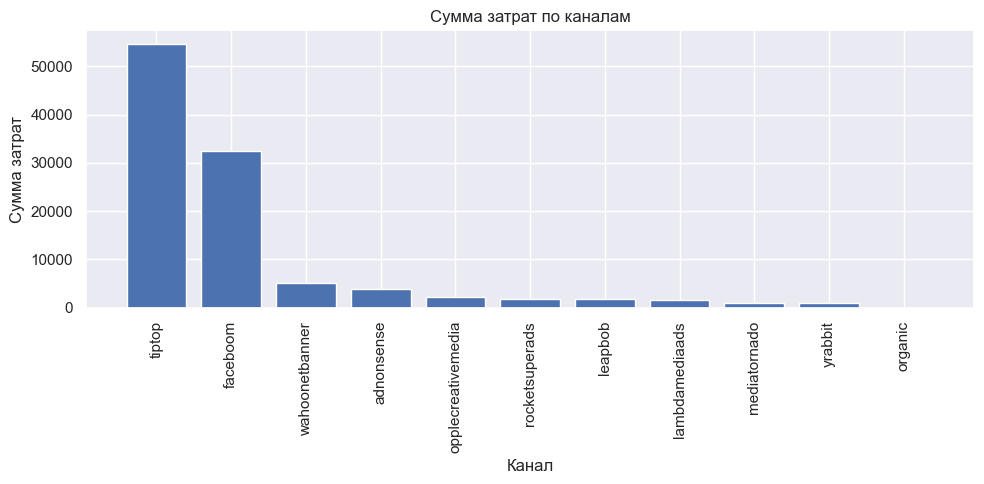

In [20]:
# Рассчитаем общую стоимость привлечения для каждого канала
cost = profiles.groupby('channel')['acquisition_cost'].sum().reset_index()

# Переименуем столбцы
cost.columns = ['channel', 'cost']

# Рассчитаем общую сумму расходов
total_cost = cost['cost'].sum()

# Рассчитаем долю общих расходов для каждого канала
cost['cost_share'] = cost['cost'] / total_cost * 100 

# Отсортируем по расходам в порядке убывания
cost = cost.sort_values(by='cost', ascending=False)

# Выводим 
display(cost.style.format({'cost':'{:.2f}', 'cost_share':'{:.2f}%'}).background_gradient(cmap='Blues', axis=0))

# Создаем столбчатую диаграмму
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму с каналами по оси x и расходами по оси y
plt.bar(cost['channel'], cost['cost'])


plt.xlabel('Канал')
plt.ylabel('Сумма затрат')
plt.title('Сумма затрат по каналам')

# Поворачиваем метки по оси x для лучшей читаемости
plt.xticks(rotation=90)

# Улучшаем компоновку диаграммы
plt.tight_layout()


plt.show()

Построена гистограмма суммы затрат на рекламу по каналам привлечения, из чего видно следующее:
   * Наибольшая сумма затрат приходится на канал tiptop - 54751,3 
   * Наименьшая сумма затрат приходится на канал yrabbit - 944,22 

При этом канал organic вообще не требует денежных вложений

#### Динамика изменения расходов ао времени для каждого источника

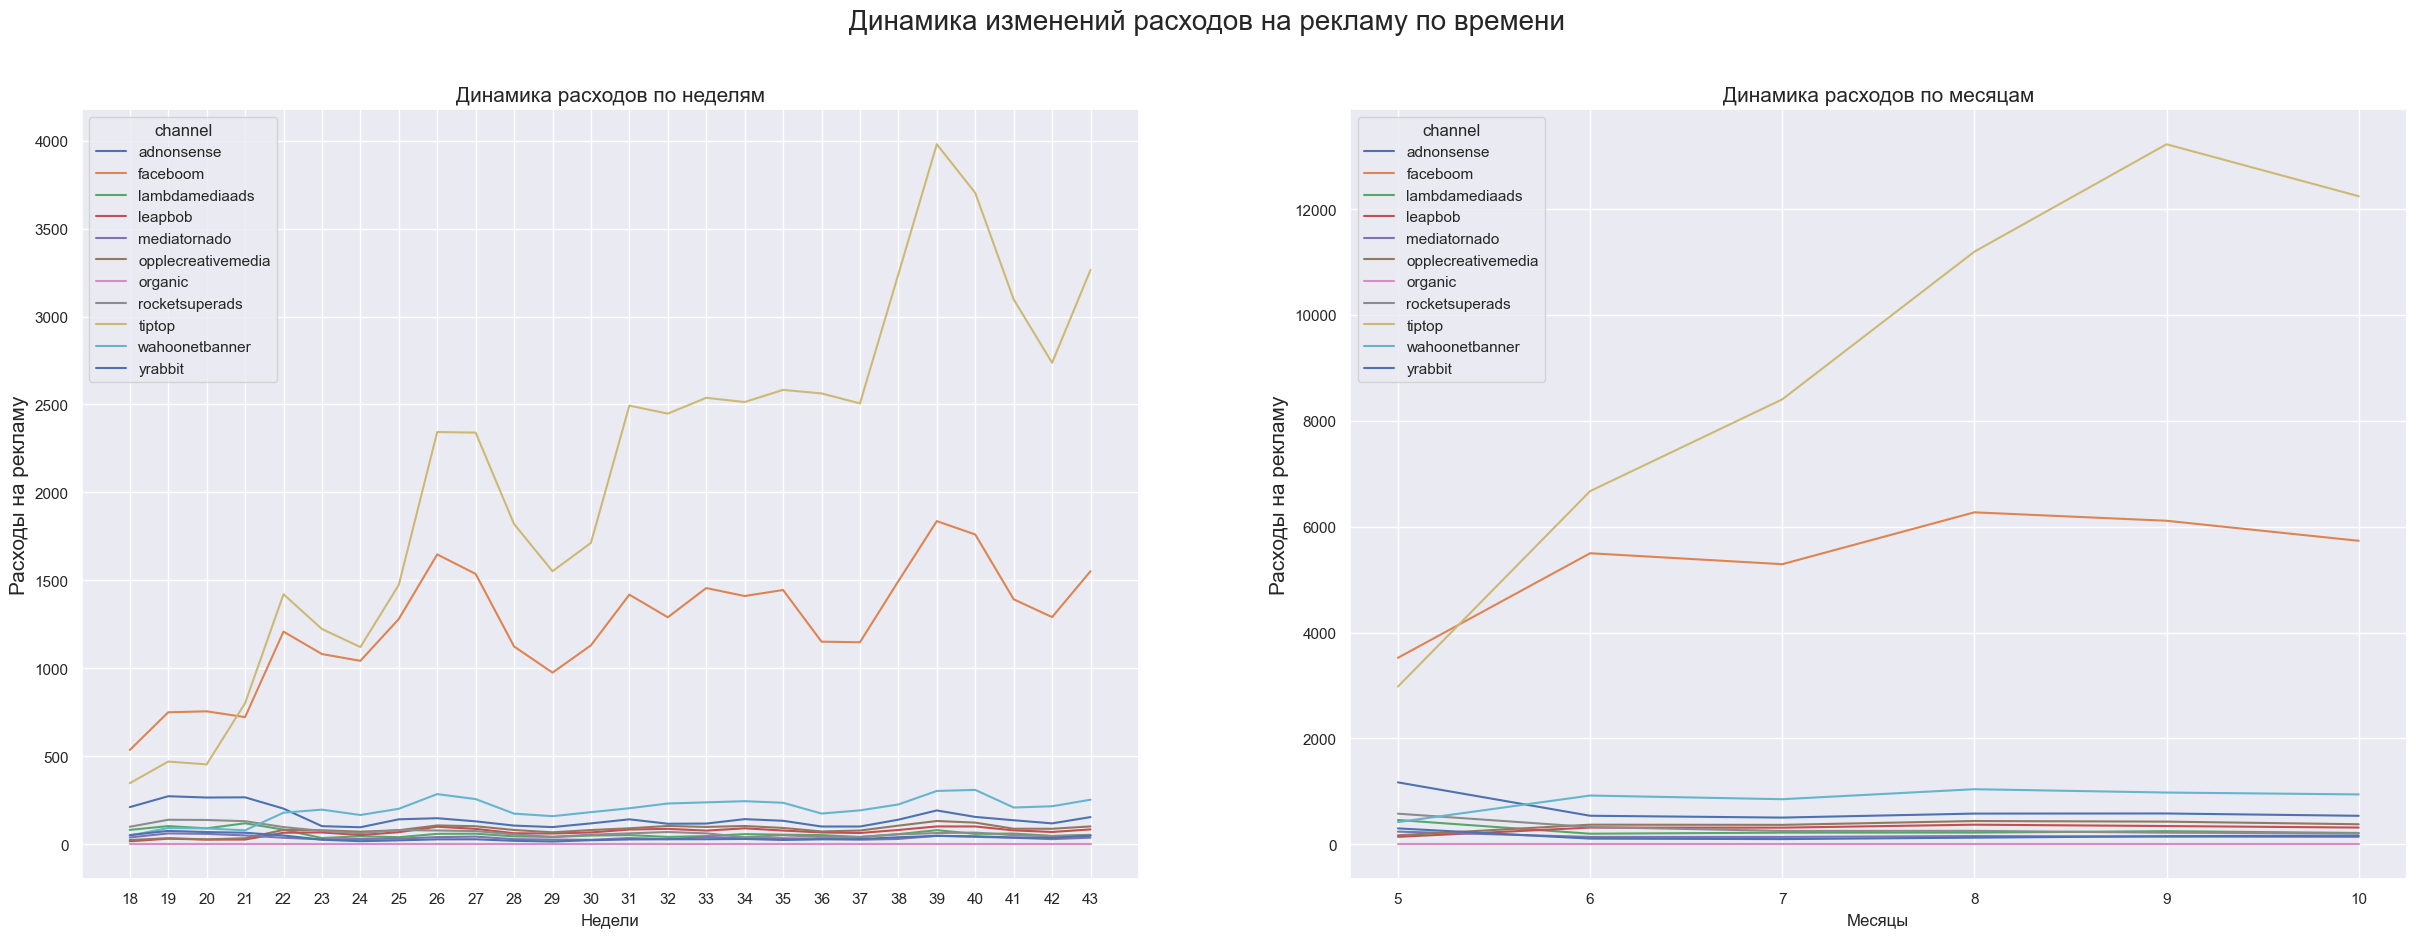

In [21]:
profiles['costs_year'] = profiles['first_ts'].dt.year
profiles['costs_month'] = profiles['first_ts'].dt.month
profiles['costs_week'] = profiles['first_ts'].dt.isocalendar().week

report_week = profiles.pivot_table(index='channel', columns='costs_week', values='acquisition_cost', aggfunc='sum')
report_month = profiles.pivot_table(index='channel', columns='costs_month', values='acquisition_cost', aggfunc='sum')

plt.figure(figsize=(30,10))
plt.suptitle('Динамика изменений расходов на рекламу по времени', fontsize=20)

report_week.T.plot(xticks=list(report_week.columns.values), ax=plt.subplot(1,2,1))
plt.xlabel('Недели')
plt.ylabel('Расходы на рекламу', fontsize=15)
plt.title('Динамика расходов по неделям', fontsize=15)

report_month.T.plot(xticks=list(report_month.columns.values), ax=plt.subplot(1,2,2))
plt.xlabel('Месяцы')
plt.ylabel('Расходы на рекламу', fontsize=15)
plt.title('Динамика расходов по месяцам', fontsize=15)
plt.show()

По динамике расходов на рекламу по времени (неделя, месяц), видно что расходы на рекламу каналов tiptop и faceboom растут. При этом недельный и помесячный расходы на рекламу остальных каналов остаются практически на одном уровне.

#### Средняя стоимость привлечения одного пользователя (САС) по каждому источнику

In [22]:
# строим график истории изменений CAC по каналам привлечения

cac = profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
).sort_values(by='acquisition_cost', ascending=False)
cac.columns = ['cac']
display(cac.style.format({'cac':'{:.2f}'}).background_gradient(cmap='Blues', axis=0))

,cac
channel,
tiptop,2.80
faceboom,1.11
adnonsense,1.01
lambdamediaads,0.72
wahoonetbanner,0.60
rocketsuperads,0.41
opplecreativemedia,0.25
yrabbit,0.22
mediatornado,0.22


Построена таблица средней стоимости привлечения одного пользователя (САС) по каналам привлечения, из чего видно следующее:
   * Наибольшая средняя стоимость привлечения одного пользователя (САС) у канала tiptop - 2,80 
   * Наименьшая средняя стоимость привлечения одного пользователя (САС) у канала leapbob - 0.21
   
При этом стоимость пользователей канала organic нулевая, т.к. данный канал вообще не требует денежных вложений

**Вывод**

По результатам анализа бюджета на маркетинг можно сделать следующие выводы:

* Общая сумма расходов на маркетинг составляет 105497.30.

* Из гистограммы затрат на рекламу по каналам привлечения видно, что наибольшие затраты приходятся на канал "tiptop" с суммой     54751.3, в то время как наименьшие затраты у "yrabbit" с суммой 944.22. Также стоит отметить, что канал "organic" не требует   дополнительных финансовых вложений.

* По динамике расходов на рекламу видно, что расходы на каналы "tiptop" и "faceboom" растут, в то время как недельные и           помесячные расходы на другие каналы остаются стабильными.

* В таблице средней стоимости привлечения одного пользователя (САС) по каналам видно, что наибольшая стоимость у "tiptop"         (2.80), а наименьшая у "leapbob" (0.21). Канал "organic" имеет нулевую стоимость привлечения, так как не требует финансовых     вложений.

Исходя из этой информации, можно предложить сосредоточить усилия на оптимизации затрат в канале "tiptop", учитывая его высокую стоимость привлечения пользователя, и продолжить масштабирование каналов "leapbob" и "organic", так как они показывают хорошие результаты по САС.

### Оценка окупаемости рекламы

In [23]:
# исключаем из анализа органических пользователей
profiles = profiles.query('channel != "organic"')

In [24]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

#### Окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

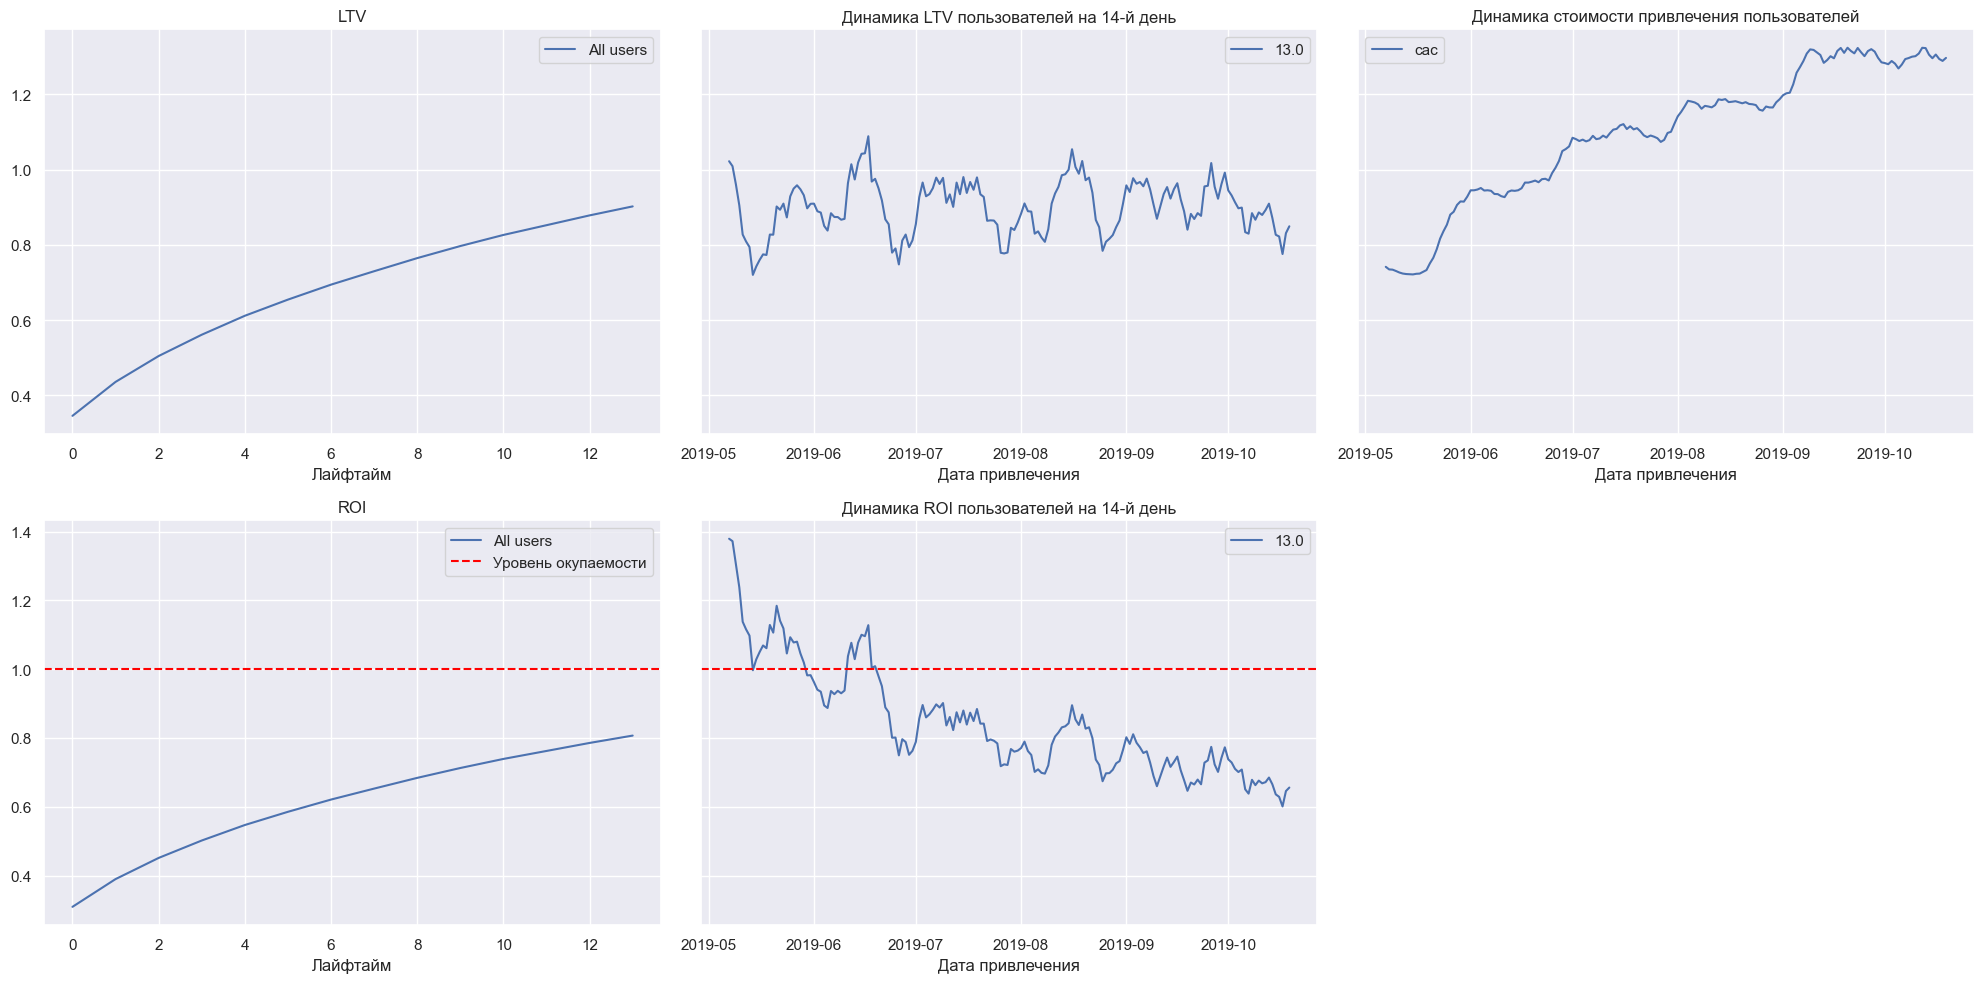

In [25]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
* Реклама не окупается
* ROI в конце второй недели — чуть выше 80%
* CAC растет. Возможно, дело в увеличении рекламного бюджета
* На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей

#### Окупаемость рекламы с разбивкой по устройствам

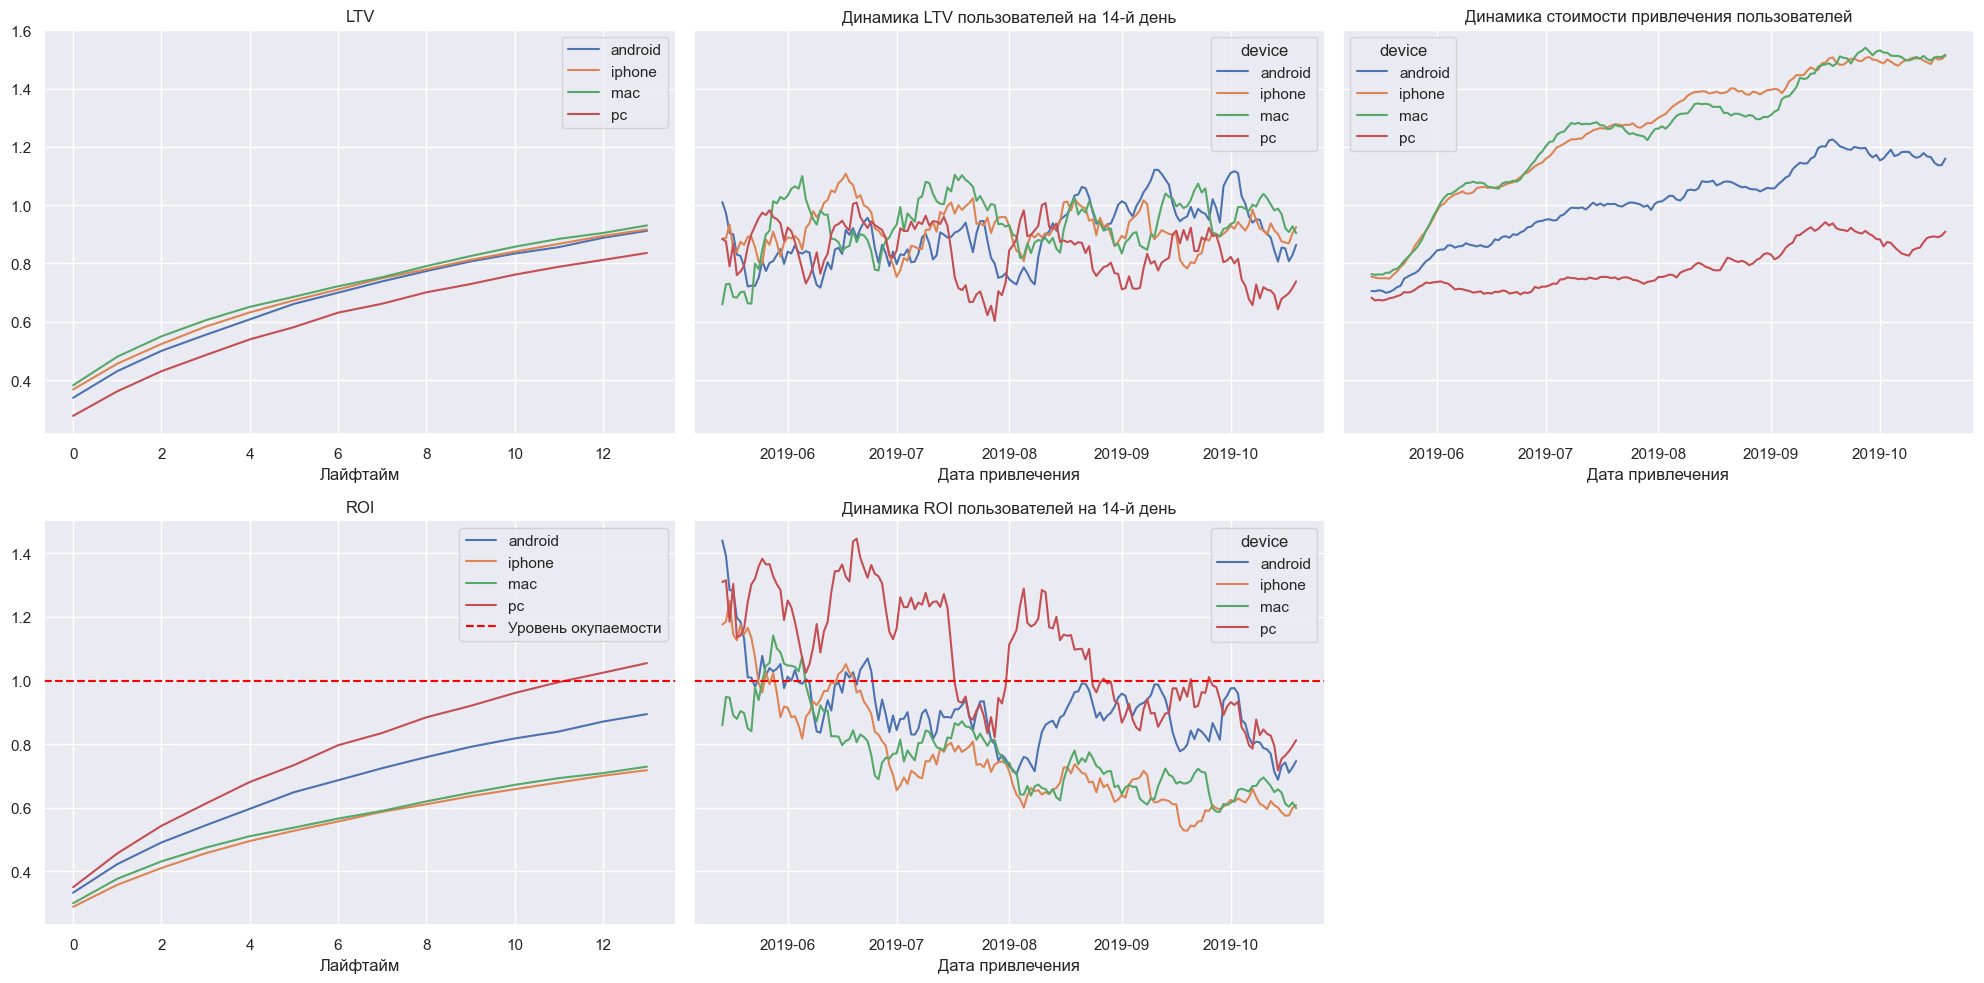

In [26]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать такие выводы:
* Реклама окупается только для пользователей PC. Самая низкая окупаемость у пользователей Мас и iPhone
* Стоимость привлечения растет для всех устройств. Самая высокая стоимость привлечения у пользователей Мас и iPhone, а низкая у пользователей PC
* LTV всё так же подвержен сезонности, но стабилен

#### Окупаемость рекламы с разбивкой по странам

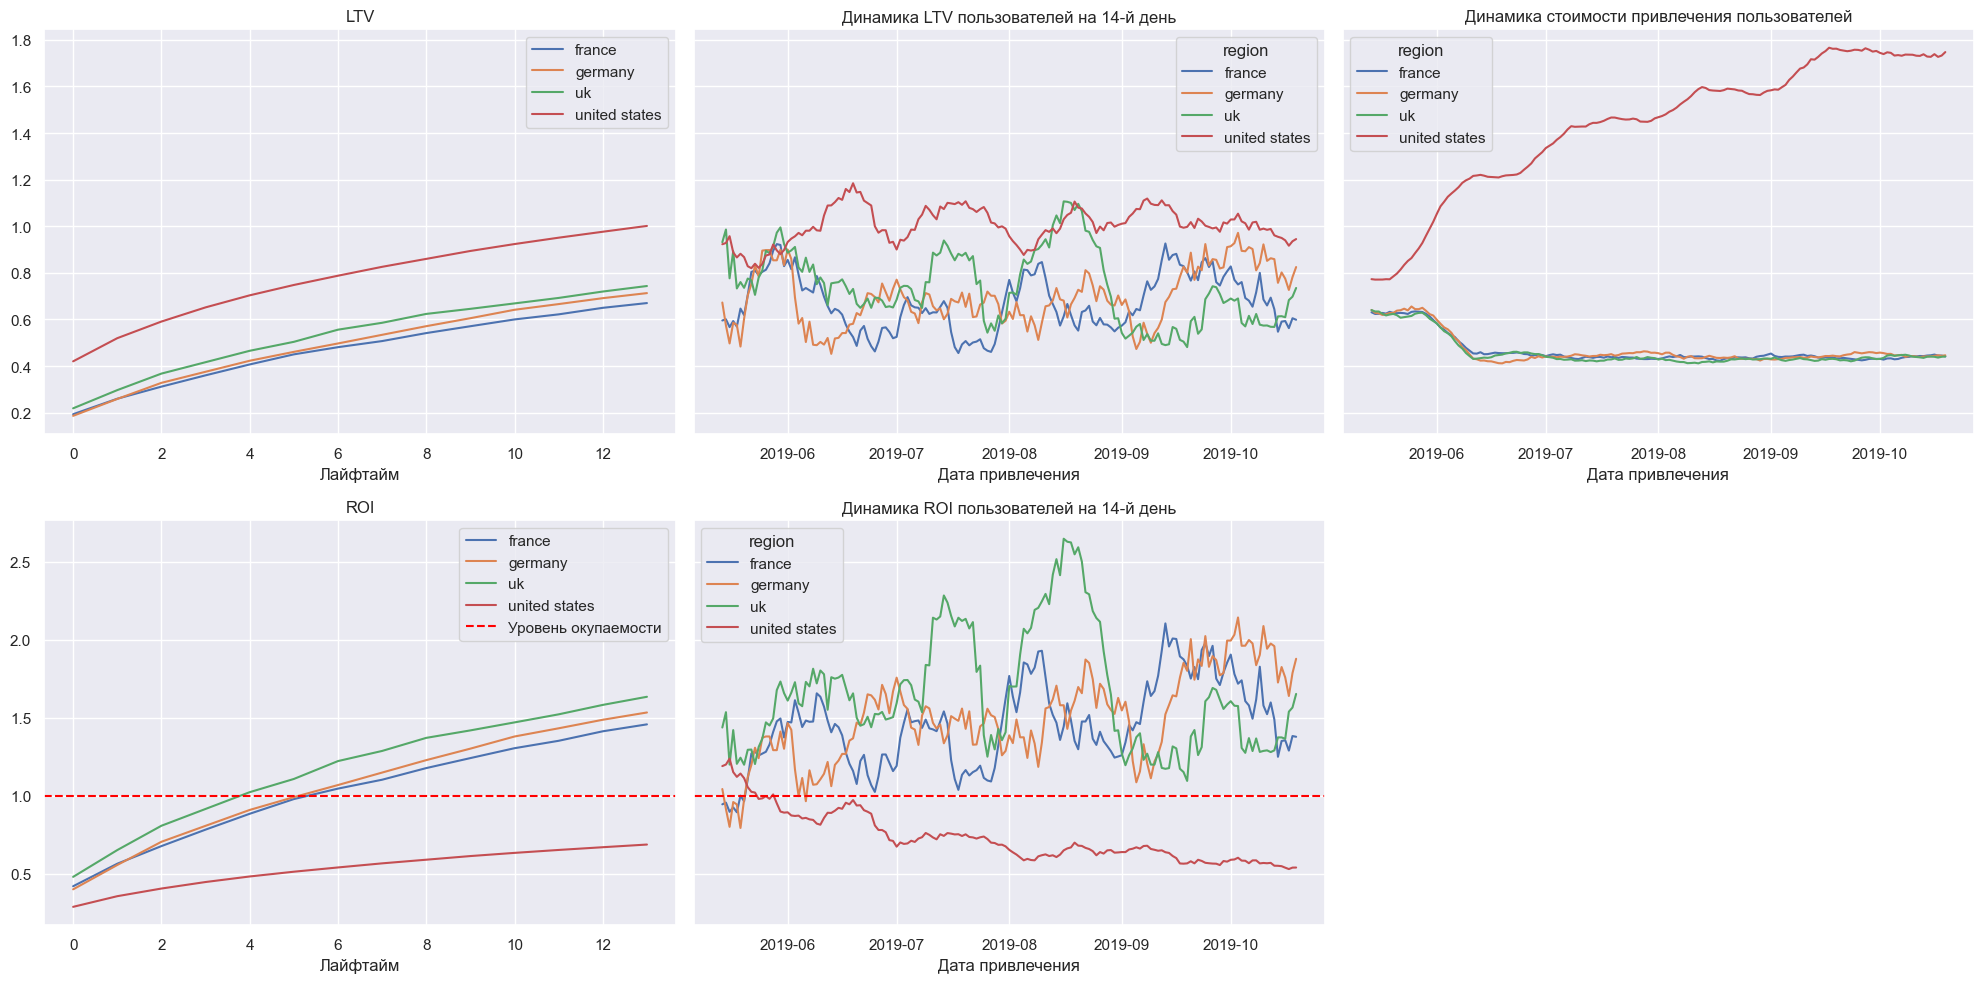

In [27]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать такие выводы:
* Реклама окупается везде кроме США, при этом окупаемость в США стабильно падает
* Стоимость привлечения стабильно растет для США и практически одинакова для остальных стран
* LTV всё так же подвержен сезонности, но стабилен
* Лучше всего окупается Великобритания

#### Окупаемость рекламы с разбивкой по источникам привлечения

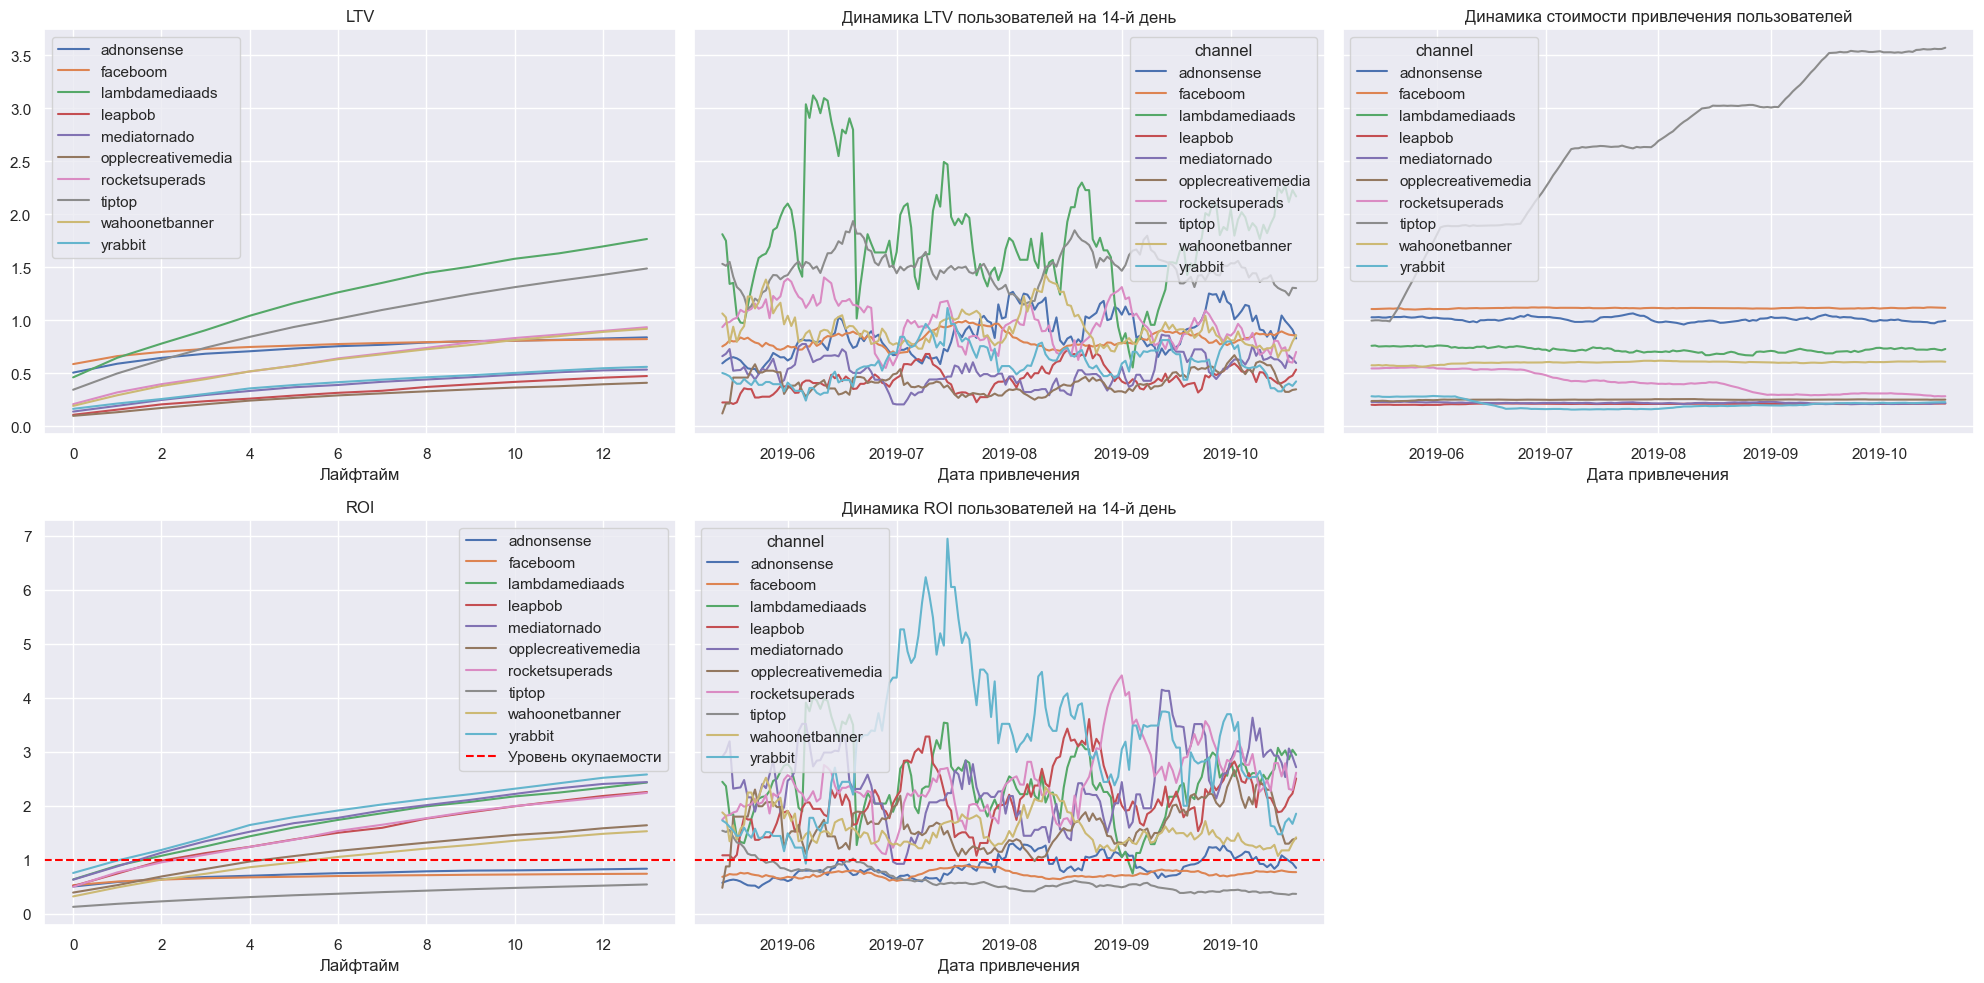

In [28]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать такие выводы:
* Реклама окупается для всех источников привлечения кроме adnonsense, faceboom, tiptop
* Стоимость привлечения растет практически стабильна для всех источников привлечения кроме постоянно растущей стоимости источника tiptop.
* LTV всё так же подвержен сезонности, но стабилен

#### Проверяем конверсию пользователей и динамику её изменения

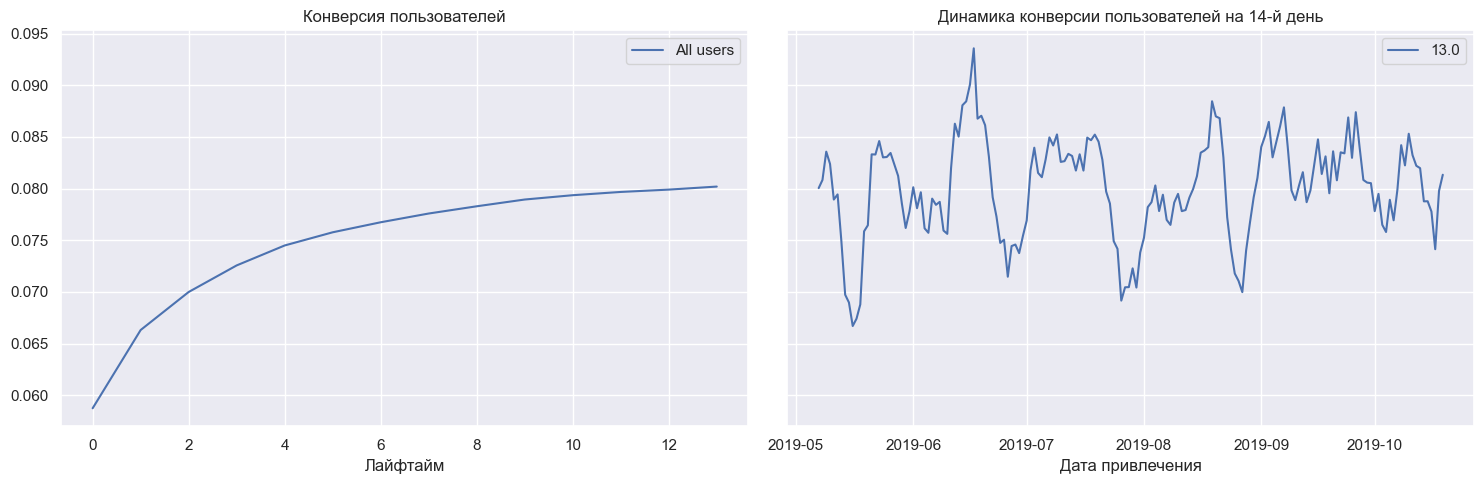

In [29]:
# смотрим конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам можно сделать такие выводы:
* Конверсия пользователей растет
* Динамика конверсии пользователей практически стабильна

#### Проверяем конверсию пользователей и динамику её изменения по устройствам

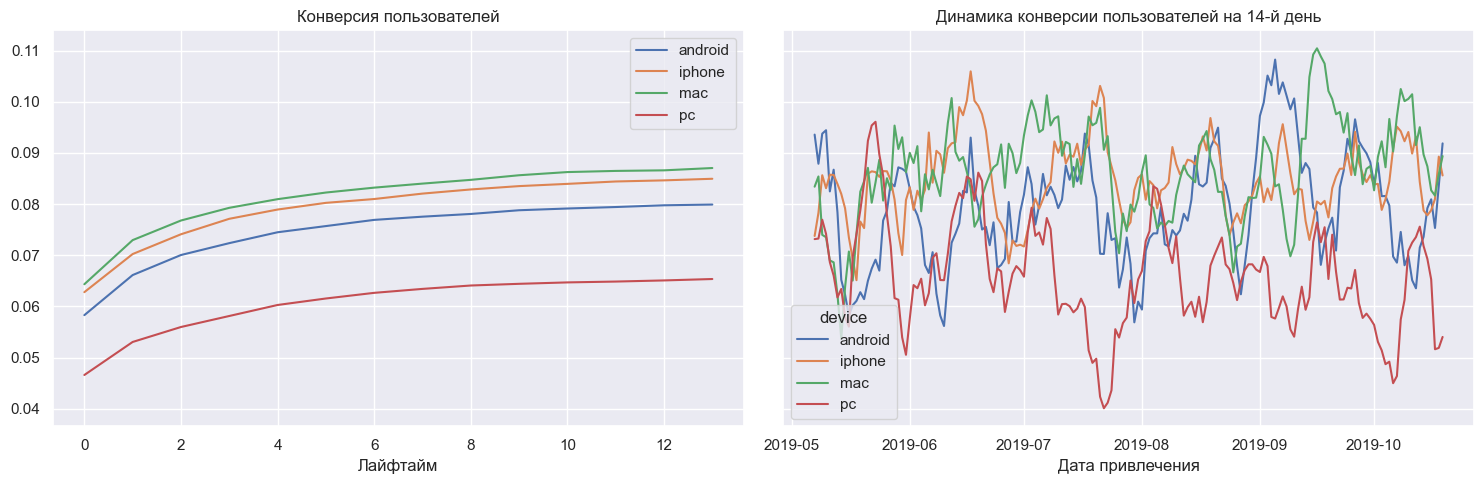

In [30]:
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам можно сделать такие выводы:
* Конверсия пользователей по устройствам растет. Наибольшая конверсия пользователей у Mac, а наименьшая у пользователей PC
* Динамика конверсии пользователей практически стабильна

#### Проверяем конверсию пользователей и динамику её изменения по странам

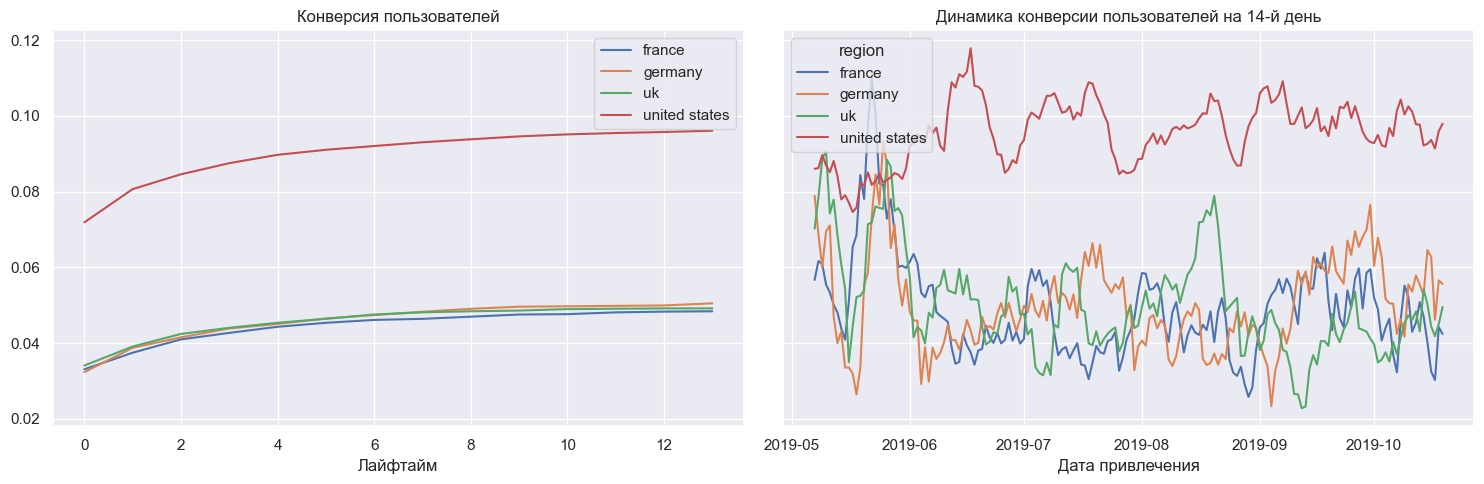

In [31]:
# смотрим конверсию с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам можно сделать такие выводы:
* Конверсия пользователей по странам растет. Наибольшая конверсия пользователей из США, а наименьшая у пользователей из Франции
* Динамика конверсии пользователей практически стабильна. Наибольшая динамика у пользователей из США

#### Проверяем конверсию пользователей и динамику её изменения по источникам привлечения

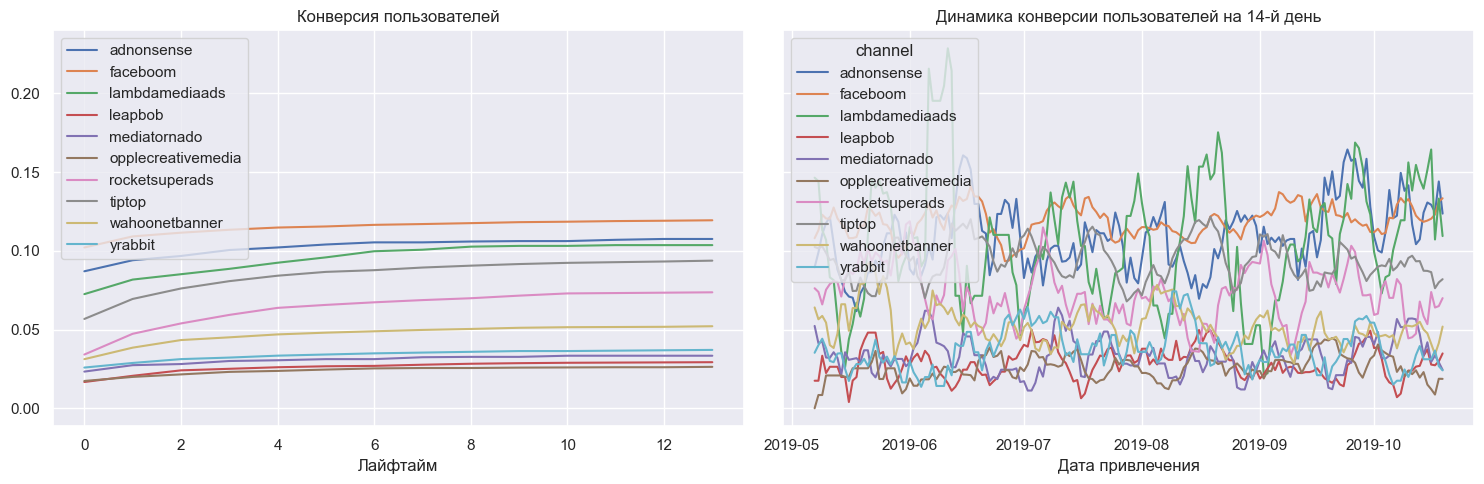

In [32]:
# смотрим конверсию с разбивкой по источникам привлечения

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам можно сделать такие выводы:
* Конверсия пользователей по источникам привлечения растет незначительно. Наибольшая конверсия пользователей пришли из канала faceboom, а наименьшая у пользователей из канала opplecreativemedia
* Динамика конверсии пользователей практически стабильна

#### Проверяем удержание пользователей и динамику её изменения

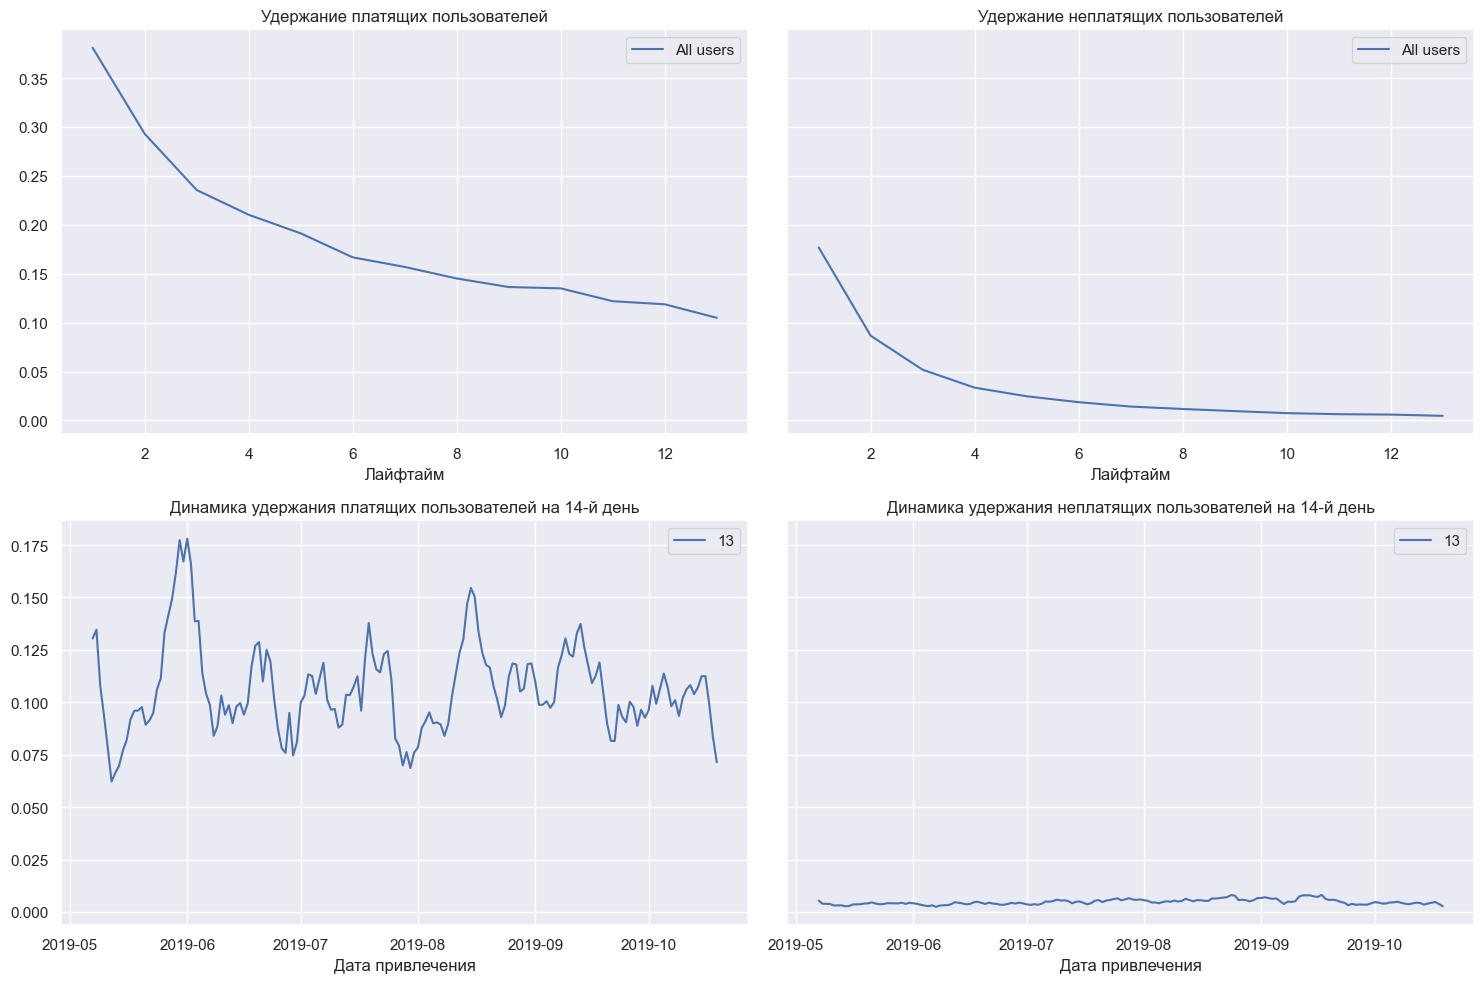

In [33]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам можно сделать такие выводы:
* Удержание стабильно падает.
* Динамика удержания пользователей стабильна, как для платящих так и для неплатящих

При этом удержание платящих пользователей выше

#### Проверяем удержание пользователей и динамику её изменения по устройствам

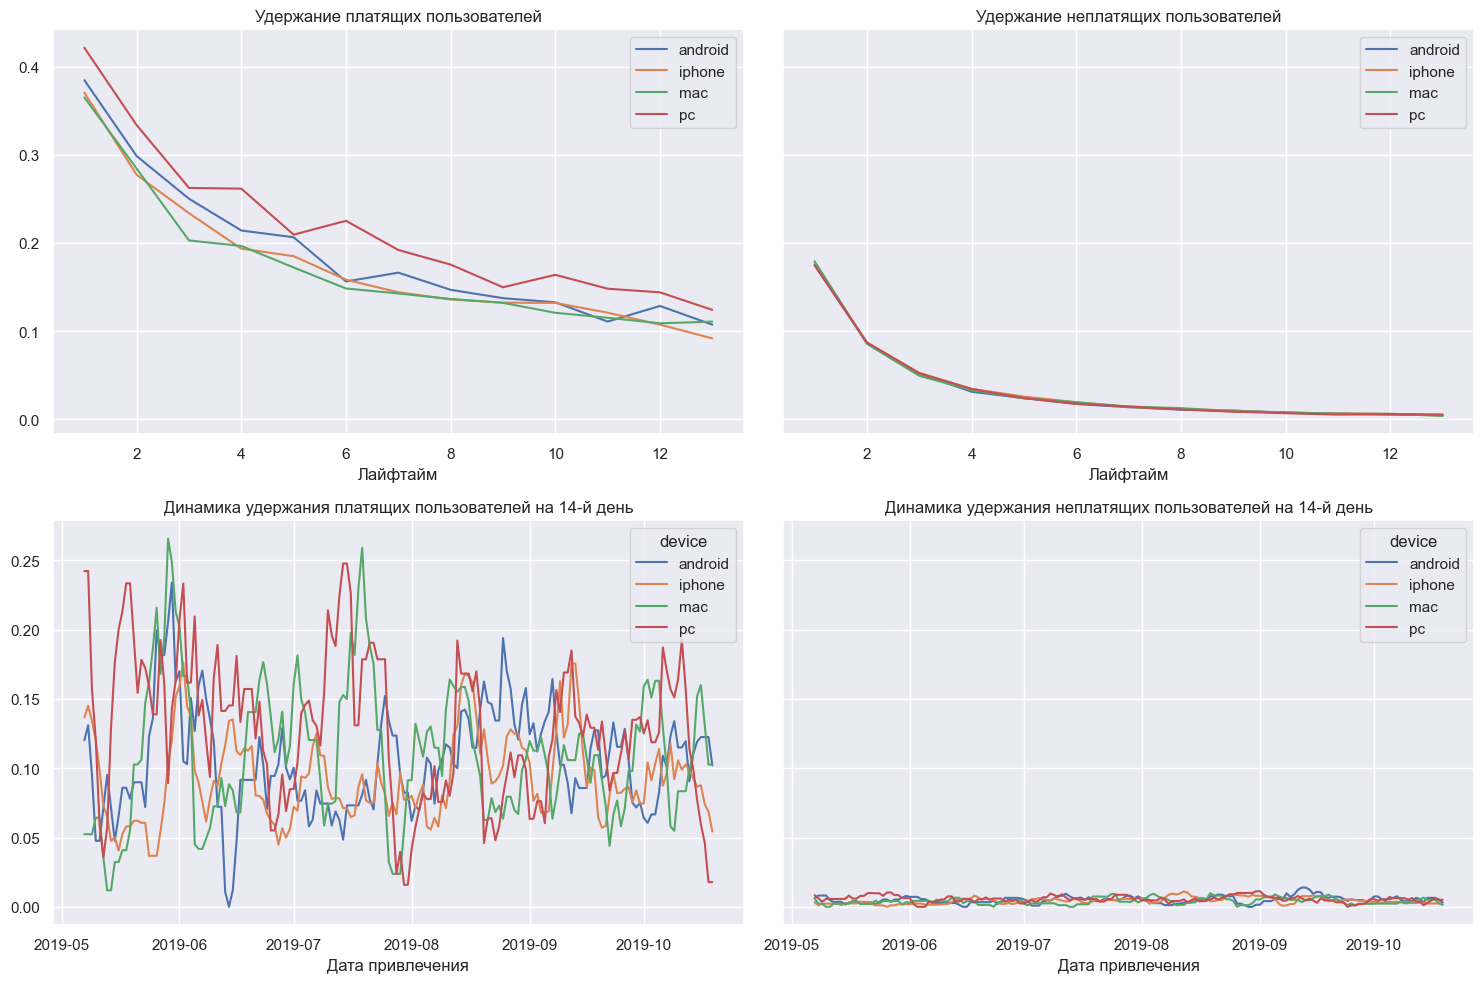

In [34]:
# смотрим удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам можно сделать такие выводы:
* Удержание пользователей по устройствам стабильно падает. Лучше всего удерживаются платящие пользователи PC, хуже платящие пользователи Mac
* Динамика удержания пользователей по устройствам стабильна, как для платящих так и для неплатящих

При этом удержание платящих пользователей выше

#### Проверяем удержание пользователей и динамику её изменения по странам

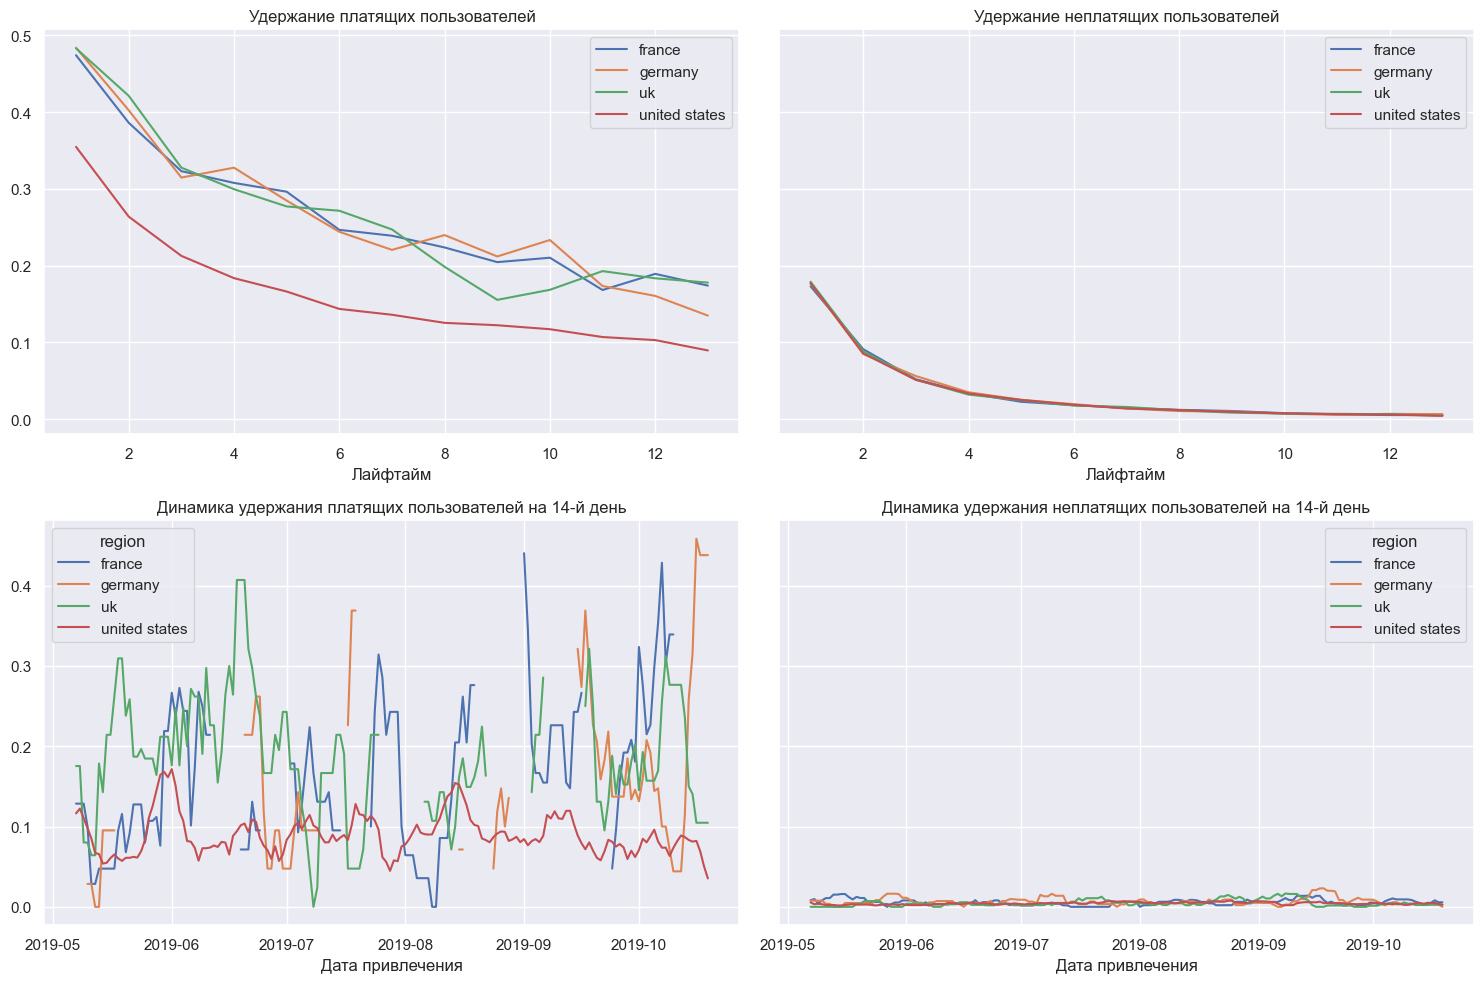

In [35]:
# смотрим удержание с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам можно сделать такие выводы:
* Удержание пользователей по странам стабильно падает. Хуже всего удерживаются платящие пользователи из США, платящие пользователи из остальных стран удерживаются практически на одном уровне
* Динамика удержания пользователей по странам стабильна, как для платящих так и неплатящих 

При этом удержание платящих пользователей выше

#### Проверяем удержание пользователей и динамику её изменения по источникам привлечения

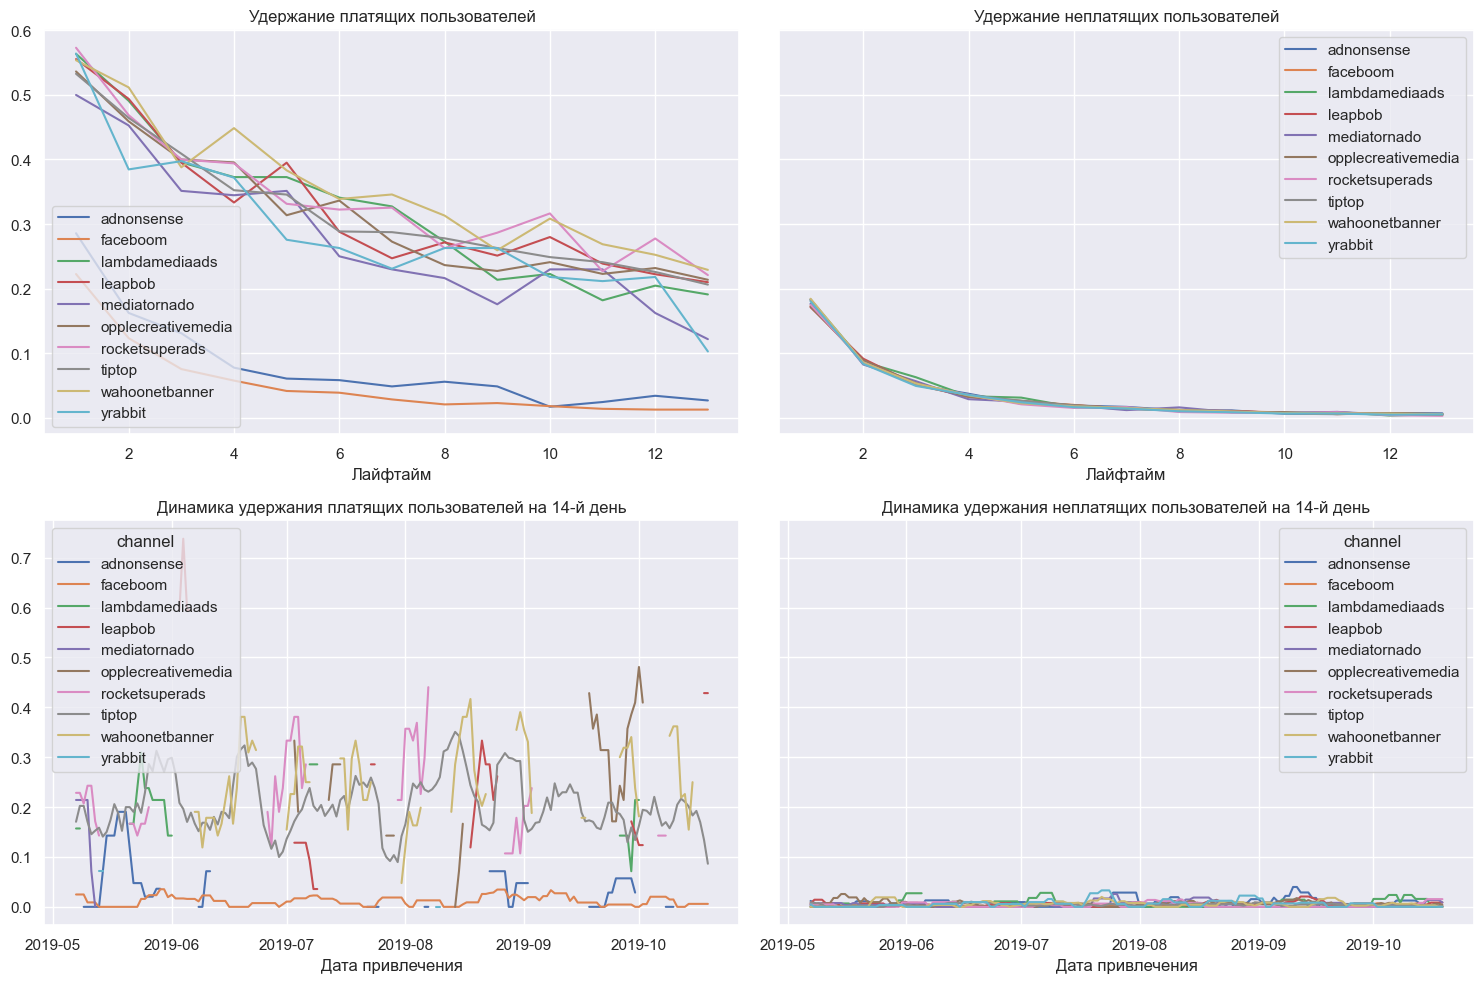

In [36]:
# смотрим удержание с разбивкой по источникам привлечения

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам можно сделать такие выводы:
* Удержание пользователей по источникам привлечения стабильно падает. Хуже всего удерживаются платящие пользователи каналов faceboom и adnonsense, платящие пользователи из остальных каналов удерживаются практически на одном уровне
* Динамика удержания пользователей по источникам привлечения стабильна, как для платящих так и неплатящих 

При этом удержание платящих пользователей выше

**Вывод**

Из проведенного анализа данных можно сделать следующие основные выводы:

**Окупаемость и ROI:**
Общая окупаемость рекламы не подтверждается данными, так как ROI в конце второй недели составляет чуть выше 80%. Это означает, что вложенные средства начинают окупаться после определенного времени.

**CAC (Стоимость привлечения пользователя):**
CAC растет, что может быть связано с увеличением рекламного бюджета. Важно обратить внимание на контроль над расходами.

**LTV (Жизненная ценность клиента):**
LTV подвержен сезонным факторам, но в целом стабилен. Это указывает на то, что качество пользователей не ухудшается со временем.

**Окупаемость по устройствам:**
Реклама окупается только для пользователей на PC, в то время как окупаемость для пользователей на Mac и iPhone ниже. Стоит проанализировать причины низкой окупаемости на этих устройствах.

**Окупаемость по странам:**
Реклама окупается везде, кроме США, где окупаемость стабильно падает. Это может потребовать пересмотра рекламных стратегий для американского рынка.

**Окупаемость по источникам привлечения:**
Реклама окупается для большинства источников привлечения, кроме "adnonsense", "faceboom" и "tiptop". Стоит рассмотреть оптимизацию затрат на эти источники.

**Конверсия пользователей:**
Конверсия пользователей растет, что является позитивным сигналом. Это может быть результатом улучшения пользовательского опыта или эффективных маркетинговых усилий.

**Удержание пользователей:**
Удержание пользователей стабильно падает, как для платящих, так и для неплатящих. Это требует внимания и мер по улучшению удержания пользователей.

**Удержание по устройствам, странам и источникам привлечения:**
Удержание пользователей по устройствам и странам также стабильно падает. Лучшее удержание у платящих пользователей на PC из Великобритании. Удержание для разных источников привлечения также различается и требует анализа и дополнительных мероприятий.


Исходя из этих выводов, рекомендуется более тщательно мониторить и оптимизировать расходы, а также разработать стратегии по улучшению удержания пользователей и повышению окупаемости рекламы в США и для определенных источников привлечения.

### ВЫВОД

**Окупаемость рекламы:**
Общая окупаемость рекламы не подтверждается данными, так как ROI в конце второй недели составляет чуть выше 80%. Это означает, что вложенные средства начинают окупаться после определенного времени. Окупаемость зависит от множества факторов, включая устройства, страны и рекламные источники.

**Устройства, страны и рекламные каналы с негативным влиянием на окупаемость:**

* **Устройства:** Реклама окупается только для пользователей на PC, в то время как окупаемость для пользователей на Mac и iPhone ниже. Это может быть вызвано различиями в пользовательском опыте или целевой аудитории на разных устройствах.

* **Страны:** Окупаемость рекламы снижается в США. Это может быть связано с конкурентной средой или недостаточно эффективными рекламными стратегиями для этого рынка.

* **Рекламные каналы:** Реклама окупается не для всех источников привлечения. "AdNonsense", "TipTop" и "FaceBoom" выделяются как менее эффективные источники. Возможно, проблемы связаны с низким качеством трафика или нецелевой аудиторией.

Среди всех источников TipTop и FaceBoom охватывают больше всего пользователей, при этом они не окупаются.

**Анализ источников "TipTop" и "FaceBoom":**

* **TipTop:** Несмотря на большой охват пользователей, стоимость привлечения (CAC) в этом канале составляет 2.80, что является одним из самых высоких показателей. Однако важно также учесть, что CAC может быть высоким, но окупаемость в будущем может быть достигнута, если клиенты, привлеченные через TipTop, имеют высокую пожизненную ценность (LTV).

* **FaceBoom:** Этот канал имеет высокую конверсию пользователей, но все равно не окупается. Это может быть связано с низкой LTV, исследование поведения пользователей, привлеченных через FaceBoom, может помочь выявить причины низкой окупаемости. Также стоит рассмотреть возможность оптимизации бюджета в этом канале. Также необходимо заметить низкие показатели удержания и динамики удержания пользователей.

**Причины проблем с окупаемостью:**

* **Высокие затраты на рекламу:** Увеличение CAC может быть связано с ростом рекламного бюджета без учета эффективности.

* **Нецелевой трафик:** Некоторые рекламные каналы могут приводить к нецелевому трафику, что снижает конверсию.

* **Низкое удержание пользователей:** Падение удержания как для платящих, так и для неплатящих клиентов, может означать, что пользовательский опыт или качество услуги требуют улучшения.

**Рекомендации:**

Исходя из вышеуказанных данных и анализа, следует принять следующие меры:

* **Мониторинг и оптимизация:** Регулярно мониторить окупаемость рекламных кампаний и контролировать бюджет. Оптимизировать затраты на менее эффективные источники привлечения.

* **Улучшение удержания:** Разработать стратегии для улучшения удержания клиентов. Может потребоваться улучшение пользовательского опыта или предоставление дополнительных стимулов для клиентов.

* **Анализ рынка США:** Провести дополнительный анализ рынка в США, чтобы определить причины снижения окупаемости и разработать соответствующие меры.

* **Тестирование устройств:** Провести тестирование и анализ различных устройств, чтобы определить, какие из них имеют потенциал для увеличения окупаемости.

* **Инновации в рекламе:** Рассмотреть возможность внедрения новых рекламных стратегий или креативных подходов для увеличения эффективности рекламных кампаний.

**Рекомендации для отдела маркетинга:**

* **Каналы с высокой окупаемостью:** Основываясь на текущих метриках, "Lambdamediaads" с высокой конверсией (10.47%) и низким CAC (0.72) стоит рассмотреть для увеличения рекламных инвестиций.

* **Оптимизация TipTop и FaceBoom:** Однако для каналов "TipTop" и "FaceBoom" необходимо провести более глубокий анализ. Это может включать в себя анализ поведения пользователей и возможные причины низкой окупаемости. Возможно, потребуется пересмотр бюджета и стратегии в этих каналах.

* **Мониторинг и оптимизация:** Важно учитывать, что маркетинговая среда постоянно меняется. Регулярно мониторить и анализировать метрики для всех каналов и вносить корректировки в стратегии в соответствии с результатами.